- Late for checkout
- Implement a minimum delay between two rentals (requested check-in or checkout times are too close from an already booked rental)
- Find the right trade off:
   - Which share of our owners revenue would potentially be affected by the features ?
   - How many rentals would be affected by the features depending on the threshold and scope we choose ?
   - How often drivers late for the next check-in ? How does it impact the next drivers ?
   - How many problematic cases will it solve depending on the chosen threshold and scope ?

What do do: 

- Build a web dashboard (response questions) using streamlit
- Pricing optimization: provide at least one endpoint /predict (url) and accept post method with JSON  input data and it should return prediction
- API: /docs, include at least an h1 title and a description of every endpoint the user can call with the endpoint name (http method)
- Have to host the API online (hugging face)

To help you start with this project we provide you with some pieces of advice:

* Spend some time understanding data 
* Don't overlook Data Analysis part, there is a lot of insights to find out. 
* Data Analysis should take 2 to 5 hours 
* Machine Learning should take 3 to 6 hours 
* You are not obligated to use libraries to handle your Machine Learning workflow like `mlflow` but we definitely advise you to do so.


Deliverable:

- The whole code stored in a Github repository. You will include the repository's URL.
- README.md file with a quick description about this project, how to setup locally and the online URL.
- A dashboard in production
- - An documented online API on Hugging Face server (or any other provider you choose) containing at least one `/predict` endpoint** that respects the technical description above. We should be able to request the API endpoint `/predict` using `curl`:

```shell
$ curl -i -H "Content-Type: application/json" -X POST -d '{"input": [[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45, 8.8]]}' http://your-url/predict
```

Or Python:

```python
import requests

response = requests.post("https://your-url/predict", json={
    "input": [[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45, 8.8]]
})
print(response.json())
```


In [1]:
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Chemins des fichiers
delay_analysis_path = "/Users/morgan/Library/Mobile Documents/com~apple~CloudDocs/JEDHA/FULL STACK/PROJECTS/9: Getaround/get_around_delay_analysis.xlsx"
pricing_optimization_path = "/Users/morgan/Library/Mobile Documents/com~apple~CloudDocs/JEDHA/FULL STACK/PROJECTS/9: Getaround/get_around_pricing_project.csv"

# Charger les données
delay_data = pd.read_excel(delay_analysis_path)
pricing_data = pd.read_csv(pricing_optimization_path)

Analyse du fichier delay_data:

In [3]:
delay_data.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [4]:
# Infos générales sur le dataframe
print(delay_data.info())

# Résumé statistique des colonnes numériques
print(delay_data.describe())

# Voir les colonnes disponibles
print(delay_data.columns)

# Voir les types de données
print(delay_data.dtypes)

missing_values_delay = delay_data.isnull().sum()
missing_values_delay


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB
None
           rental_id         car_id  delay_at_checkout_in_minutes  \
count   21310.000000   21310.000000                  16346.000000   
mean   549712.880338  350030.6

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64

**Analyse:**

Nombre total de lignes : 21 310 

Nombre total de colonnes : 7

Types de données :

2 colonnes numériques entières (int64) : rental_id, car_id

2 colonnes de type texte (object) : checkin_type, state

3 colonnes numériques (float64) : 

delay_at_checkout_in_minutes= heure prévue/heure réelle
previous_ended_rental_id= id location précédente
time_delta_with_previous_rental_in_minutes= temps entre fin de location et suivante

Retard:

- Moyenne: 59,7 min (acceptable)
- Min: 22,43 min
- Max: 71,08 min
- 4964 valeurs manquantes (4924 X 100 / 21310: 23%)

Intervalle entre deux locations:

- Moyenne: 279min /60: 4h30
- Min: 0min 
- 720 min (12h)
- Majeure partie des valeurs sont manquantes

**A faire:**

- Valeurs nulles et location annulées
- Dernière colonne majoritairement vide.

Analyse du fichier pricing_data:

In [5]:
pricing_data.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [6]:
# Infos générales sur le dataframe
print(pricing_data.info())

# Résumé statistique des colonnes numériques
print(pricing_data.describe())

# Voir les colonnes disponibles
print(pricing_data.columns)

# Voir les types de données
print(pricing_data.dtypes)

missing_values_pricing = pricing_data.isnull().sum()
missing_values_pricing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

Unnamed: 0                   0
model_key                    0
mileage                      0
engine_power                 0
fuel                         0
paint_color                  0
car_type                     0
private_parking_available    0
has_gps                      0
has_air_conditioning         0
automatic_car                0
has_getaround_connect        0
has_speed_regulator          0
winter_tires                 0
rental_price_per_day         0
dtype: int64

**Analyse:**

- Colonnes inutiles
- Valeurs booléennes
- Variable cible: rental_price_per_day pour le Machine learning

Prix de location:

- Moyenne: 121€ par jour
- Min 10€, max 422€ par jour
- Pas de valeurs manquantes

Nettoyage des valeurs aberrantes:

In [7]:
# Nettoyage des valeurs aberrantes dans delay_at_checkout_in_minutes
delay_data_cleaned = delay_data.copy()
delay_data_cleaned = delay_data_cleaned[
    (delay_data_cleaned["delay_at_checkout_in_minutes"] >= 0) & 
    (delay_data_cleaned["delay_at_checkout_in_minutes"] <= 5000)  # Suppression des valeurs extrêmes
]

# Nettoyage du kilométrage négatif
pricing_data_cleaned = pricing_data.copy()
pricing_data_cleaned = pricing_data_cleaned[pricing_data_cleaned["mileage"] >= 0]

# Nettoyage de la puissance moteur nulle
pricing_data_cleaned = pricing_data_cleaned[pricing_data_cleaned["engine_power"] > 0]

# Vérifier les nouvelles statistiques après nettoyage
delay_stats_cleaned = delay_data_cleaned.describe()
pricing_stats_cleaned = pricing_data_cleaned.describe()

delay_stats_cleaned, pricing_stats_cleaned


(           rental_id         car_id  delay_at_checkout_in_minutes  \
 count    9497.000000    9497.000000                   9497.000000   
 mean   550120.072128  349427.300095                    156.235653   
 std     13475.892111   58699.372481                    367.056139   
 min    504970.000000  159250.000000                      0.000000   
 25%    541200.000000  317613.000000                     18.000000   
 50%    550638.000000  368578.000000                     52.000000   
 75%    560428.000000  394656.000000                    128.000000   
 max    576401.000000  416992.000000                   4966.000000   
 
        previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  
 count                814.000000                                  814.000000  
 mean              549351.158477                                  257.985258  
 std                13733.062156                                  247.608726  
 min               506069.000000                    

1️⃣ get_around_delay_analysis.xlsx (Retards)

Avant : 16,346 valeurs valides → Après : 9,497 valeurs valides (suppression des valeurs aberrantes).

Retard moyen : 156 min (~2h30) au lieu de 59 min (les valeurs extrêmes ont été supprimées).

Max retard : 4,966 min (~3,5 jours) au lieu de 71,084 min.

2️⃣ get_around_pricing_project.csv (Prix & caractéristiques)

Suppression des véhicules avec kilométrage négatif.

Suppression des véhicules avec puissance moteur nulle.

Peu de changements sur les stats globales.

VISUALISATION DES RETARDS ET DES PRIX DE LOCATIONS:

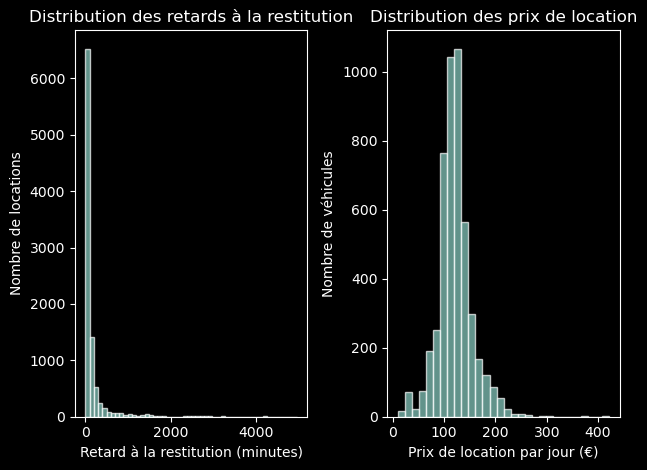

In [8]:
# Distribution des retards de restitution
plt.subplot(1, 2, 1)
plt.hist(delay_data_cleaned["delay_at_checkout_in_minutes"], bins=50, edgecolor='white', alpha=0.7)
plt.xlabel("Retard à la restitution (minutes)")
plt.ylabel("Nombre de locations")
plt.title("Distribution des retards à la restitution")

# Distribution des prix de location
plt.subplot(1, 2, 2)
plt.hist(pricing_data_cleaned["rental_price_per_day"], bins=30, edgecolor='white', alpha=0.7)
plt.xlabel("Prix de location par jour (€)")
plt.ylabel("Nombre de véhicules")
plt.title("Distribution des prix de location")

# Afficher les graphiques
plt.tight_layout()
plt.show()

1️⃣ Distribution des retards :

La majorité des locations ont des retards inférieurs à 200 minutes (~3h20).

Il y a encore quelques retards très élevés (plusieurs heures/jours).

La répartition est asymétrique avec une longue traîne.

2️⃣ Distribution des prix de location :

La plupart des locations sont entre 100€ et 140€ par jour.

Il y a quelques voitures très chères (jusqu'à 422€/jour).

In [9]:
# Analyse des retards et impact sur les locations suivantes

# Filtrer les locations qui avaient une location précédente
overlapping_rentals = delay_data_cleaned.dropna(subset=["time_delta_with_previous_rental_in_minutes"])

# Calculer le nombre de locations affectées par un délai minimum de 60, 120 et 180 minutes
thresholds = [60, 120, 180]
affected_rentals = {
    t: overlapping_rentals[overlapping_rentals["time_delta_with_previous_rental_in_minutes"] < t].shape[0]
    for t in thresholds
}

# Création d'un DataFrame pour affichage
affected_rentals_df = pd.DataFrame(list(affected_rentals.items()), columns=["Délai Minimum (min)", "Locations affectées"])
affected_rentals_df

,Délai Minimum (min),Locations affectées
0,60,198
1,120,315
2,180,410


Voici l'analyse de l'impact d'un délai minimum entre deux locations :

198 locations seraient affectées avec un délai de 60 minutes.


315 locations seraient affectées avec un délai de 120 minutes.

410 locations seraient affectées avec un délai de 180 minutes.

DEVELOPPEMENT DU DASHBOARD INTERACTIF:

- Visualisation des retards (distribution)
- Visualisation des delais
- Visualisation du nombre de locations affectées

Utiliser: streamlit run getaround_dashboard.py

DEVELOPPER MODELE:

In [13]:
# Analyse des variables du dataset "get_around_pricing_project.csv"
# Sélectionner uniquement les colonnes numériques avant de recalculer la matrice de corrélation
numeric_columns = pricing_data_cleaned.select_dtypes(include=["number"]).columns
correlation_matrix_fixed = pricing_data_cleaned[numeric_columns].corr()


Nous avons analysé les relations entre les variables et le prix de location (rental_price_per_day).

1️⃣ Variables les plus corrélées au prix :
🔼 Positivement corrélées (↑ augmente le prix) :

engine_power (+0.62) → Plus la puissance du moteur est élevée, plus le prix est élevé.
automatic_car (+0.41) → Les voitures automatiques coûtent plus cher à la location.
has_getaround_connect (+0.32) → Les véhicules connectés sont plus chers.
has_gps (+0.31) → Les voitures avec GPS ont un prix plus élevé.
private_parking_available (+0.28) → Influence modérée sur le prix.
🔽 Négativement corrélée (↓ diminue le prix) :

mileage (-0.45) → Plus le véhicule a de kilomètres, moins il est cher.
2️⃣ Analyse des variables catégoriques
Type de carburant (fuel) :
Majoritairement diesel (96%), puis essence.
Couleur (paint_color) :
Noir, gris et bleu sont les couleurs les plus courantes.
Type de voiture (car_type) :
Majoritairement estate, sedan et SUV.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Sélection des features et de la target
X = pricing_data_cleaned.drop(columns=["rental_price_per_day", "Unnamed: 0"])
y = pricing_data_cleaned["rental_price_per_day"]

# Séparer les variables numériques et catégoriques
numerical_features = ["mileage", "engine_power"]
categorical_features = ["fuel", "paint_color", "car_type"]

# Préparer le préprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Pipeline avec régression linéaire
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(14.278975951423588, 0.613373057366277)

CREATION D'UNE API:

- Charger le modèle
- Recevoir une requête avec les caractéristiques d'un véhicule
- Retourner une prédiction du prix

In [15]:
import joblib
joblib.dump(model, "getaround_pricing_model.pkl")


['getaround_pricing_model.pkl']

Instruction:

1: Installer FastAPI et Uvicorn avec pip install...

2: Sauvegarder le modèle en local
   import joblib
   joblib.dump(model, "getaround_pricing_model.pkl")

3: Créer un fichier getaround_api.py
   Importer les bibli
   Charger le modèle avec joblib.load  
   Définir l'API avec app = FastAPI()
   Définir format des entrées
   Définir Endpoint de prédiction
   Lancer l'Api 

4: Lancer l'API: python getaround_api.py

5: Teste de l'API: curl -X 'POST' 'http://127.0.0.1:8000/predict' -H 'Content-Type: application/json' -d '{
  "mileage": 50000,
  "engine_power": 120,
  "fuel": "diesel",
  "paint_color": "black",
  "car_type": "suv"
}'


- Création d'un space sur Hugging face: "getaround-api"  (docker)
- Création d'un répertoire pour le deployment de l'API : getaround_api_deploy
_ Déplacer 